<a href="https://colab.research.google.com/github/ccasadei/corso-ia/blob/master/04RetiNeurali/04OCR/ocr_mnist01.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# OCR Ricorrente con MNIST
## Esercizio 1
**Author: Cristiano Casadei**

In [1]:
%pip install tqdm opencv-python

Note: you may need to restart the kernel to use updated packages.


In [2]:
import os

# disabilito il logger di TensorFlow per avere un log pulito
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"

from tqdm import tqdm
import math
import cv2
import matplotlib.image as mpimg
import numpy as np
import tensorflow as tf
from matplotlib import pyplot as plt

In [3]:
# predispongo alcuni parametri
DATASET_DIR = "dataset"
VOCABULARY = ["0", "1", "2", "3", "4", "5", "6", "7", "8", "9"]
LABEL_LEN = 9
IMG_WIDTH, IMG_HEIGHT = 256, 32
NR_SAMPLES = 2000
TEST_SIZE = 16
TRAIN_SPLIT = 0.9
BATCH_SIZE = 16
EPOCHS = 10

In [4]:
# imposto dei seed ai generatori random, per rendere replicabili i risultati
np.random.seed(1234)
tf.random.set_seed(1234)

# se il dataset non è presente, lo preparo
if not os.path.exists(DATASET_DIR):
    print("Devo preparare il dataset")
    # ottengo il dataset MNIST già suddiviso in dataset X e Y, di addestramento e di test
    (X_train, y_train), (X_test, y_test) = tf.keras.datasets.mnist.load_data()
    # unisco il dataset train e test per ottenerne uno unico
    X_dataset = np.concatenate([X_train, X_test], axis=0)
    y_dataset = np.concatenate([y_train, y_test], axis=0)
    # preparo i samples unici del dataset
    os.makedirs(DATASET_DIR)
    samples = []
    for _ in tqdm(range(NR_SAMPLES)):
        while True:
            label = "".join(map(lambda x: VOCABULARY[x], np.random.randint(0, len(VOCABULARY), size=LABEL_LEN)))
            if label not in samples:
                samples.append(label)
                break
        img = np.zeros((28, 28 * LABEL_LEN), dtype=np.uint8)
        for pos, digit in enumerate(label):
            img[:, 28 * pos:28 * (pos + 1)] = X_dataset[np.random.choice(np.where(y_dataset == int(digit))[0], 1)[0]]
        cv2.imwrite(os.path.join(DATASET_DIR, label + ".jpg"), img)
print("Dataset preparato")

Devo preparare il dataset


100%|██████████| 2000/2000 [00:02<00:00, 700.74it/s]

Dataset preparato


In [5]:
# ottengo l'elenco dei file immagini e randomizzo l'elenco
images = list(map(lambda x: os.path.join(DATASET_DIR, x), os.listdir(DATASET_DIR)))
np.random.shuffle(images)
# dai nomi dei file ottengo le label
labels = list(map(lambda x: os.path.splitext(os.path.basename(x))[0], images))

print("Informazioni sul dataset")
print("========================")
print()
print("Immagini totali: %d" % len(images))
print("Lunghezza massima label: %d" % LABEL_LEN)
print("Vocabolario di %d caratteri" % len(VOCABULARY))
print("Vocabolario: %s" % str(VOCABULARY))

Informazioni sul dataset

Immagini totali: 2000
Lunghezza massima label: 9
Vocabolario di 10 caratteri
Vocabolario: ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']


In [6]:
# preparo la funzione che mappa dai caratteri ai codici numerici
char_to_num = tf.keras.layers.StringLookup(
    vocabulary=VOCABULARY, mask_token=None
)

# preparo la funzione che mappa dai codici numerici ai caratteri
# uso il nuovo vocabolario che contiene anche il token [UNK] per i caratteri sconosciuti
num_to_char = tf.keras.layers.StringLookup(
    vocabulary=char_to_num.get_vocabulary(), mask_token=None, invert=True
)

print("Codifica caratteri->numeri:")
for ch in VOCABULARY:
    print("'%s' -> %d" % (ch, char_to_num(tf.convert_to_tensor(ch))))
print()

print("Decodifica codice 0 (blank): '%s'" % num_to_char(tf.convert_to_tensor(0)).numpy().decode("utf8"))

Codifica caratteri->numeri:
'0' -> 1
'1' -> 2
'2' -> 3
'3' -> 4
'4' -> 5
'5' -> 6
'6' -> 7
'7' -> 8
'8' -> 9
'9' -> 10

Decodifica codice 0 (blank): '[UNK]'


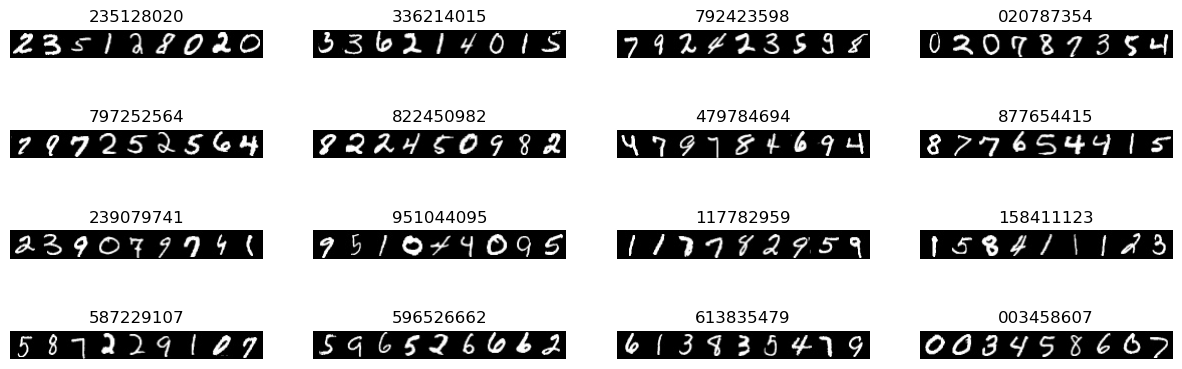

In [7]:
# ottengo il dataset di test e lo tolgo dal dataset
test_img = images[:TEST_SIZE]
test_lab = labels[:TEST_SIZE]
images = images[TEST_SIZE:]
labels = labels[TEST_SIZE:]

# visualizzo il dataset di test
_, axs = plt.subplots(4, 4, figsize=(15, 5))
for i, (imgf, label) in enumerate(zip(test_img, test_lab)):
    axs[i // 4, i % 4].imshow(mpimg.imread(imgf), cmap="gray")
    axs[i // 4, i % 4].set_title(label)
    axs[i // 4, i % 4].axis("off")

In [8]:
# suddivido il resto del dataset in training set e validation set, utilizzando la percentuale di split
num_train_samples = math.ceil(len(images) * TRAIN_SPLIT)

train_img = images[:num_train_samples]
train_lab = labels[:num_train_samples]
val_img = images[num_train_samples:]
val_lab = labels[num_train_samples:]

print("Test set: %d immagini" % len(test_img))
print("Train set: %d immagini" % len(train_img))
print("Validation set: %d immagini" % len(val_img))

Test set: 16 immagini
Train set: 1786 immagini
Validation set: 198 immagini


In [9]:
def prepara_sample(imgf, labelstr):
    # leggo l'immagine
    # la converto in scala di grigi
    # utilizzo il datatype float32
    # ridimensiono l'immagine alla dimensione di input desiderata
    # ruoto l'immagine in modo che la larghezza dell'immagine funga da dimensione temporale (timesteps)
    # NOTA: i valori sono normalizzati nel range [0, 1]
    img = tf.transpose(
        tf.image.resize(
            tf.image.convert_image_dtype(
                tf.io.decode_jpeg(
                    tf.io.read_file(imgf),
                    channels=1
                ),
                tf.float32
            ),
            [IMG_HEIGHT, IMG_WIDTH]
        ),
        perm=[1, 0, 2]
    )
    # codifico la stringa della label nella sua versione numerica
    label = char_to_num(tf.strings.unicode_split(labelstr, input_encoding="UTF-8"))

    return {"input_image": img, "input_label": label}

In [10]:
# creo degli oggetti Dataset che mi consentono di gestire i dati in maniera automatica
train_ds = tf.data.Dataset.from_tensor_slices((train_img, train_lab))
train_ds = train_ds. \
    map(prepara_sample, num_parallel_calls=tf.data.experimental.AUTOTUNE). \
    batch(BATCH_SIZE). \
    prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

val_ds = tf.data.Dataset.from_tensor_slices((val_img, val_lab))
val_ds = val_ds. \
    map(prepara_sample, num_parallel_calls=tf.data.experimental.AUTOTUNE). \
    batch(BATCH_SIZE). \
    prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

In [11]:
# definisco un nuovo layer custom per il calcolo della CTC Loss
class CTCLayer(tf.keras.layers.Layer):
    def __init__(self, name=None):
        super().__init__(name=name)
        self.loss_fn = tf.keras.backend.ctc_batch_cost

    def call(self, y_true, y_pred):
        # calcolo la CTC loss ed aggiungo il valore usando il metodo "add_loss"
        batch_len = tf.cast(tf.shape(y_true)[0], dtype="int32")
        y_pred_len = tf.cast(tf.shape(y_pred)[1], dtype="int32")
        y_true_len = tf.cast(tf.shape(y_true)[1], dtype="int32")

        y_pred_len = y_pred_len * tf.ones(shape=(batch_len, 1), dtype="int32")
        y_true_len = y_true_len * tf.ones(shape=(batch_len, 1), dtype="int32")

        loss = self.loss_fn(y_true, y_pred, y_pred_len, y_true_len)
        self.add_loss(loss)

        # restituisco la predizione per la fase di inferesi/test
        return y_pred

In [12]:
# costruisco il modello CRNN

# ingressi del modello di training (per il modello di inference verrà utilizzato solo l'input delle immagini)
input_img_layer = tf.keras.layers.Input(shape=(IMG_WIDTH, IMG_HEIGHT, 1), name="input_image", dtype="float32")
input_lab_layer = tf.keras.layers.Input(shape=(None,), name="input_label", dtype="float32")

# parte convoluzionale
x = tf.keras.layers.Conv2D(32, (3, 3), activation="relu", padding="same", kernel_initializer="he_normal", name="conv1", )(input_img_layer)
x = tf.keras.layers.MaxPooling2D((2, 2), name="pool1")(x)

x = tf.keras.layers.Conv2D(64, (3, 3), activation="relu", padding="same", kernel_initializer="he_normal", name="conv2", )(x)
x = tf.keras.layers.MaxPooling2D((2, 2), name="pool2")(x)

# converto da output convoluzionale ad input ricorrente
x = tf.keras.layers.Reshape(target_shape=(x.shape[1], x.shape[2] * x.shape[3]), name="reshape")(x)

# parte ricorrente
x = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128, return_sequences=True, dropout=0.25))(x)
x = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True, dropout=0.25))(x)

# layer di uscita (uso il vocabolario con il token [UNK] e aggiungo un valore per il [BLANK])
out_prediction = tf.keras.layers.Dense(len(char_to_num.get_vocabulary()) + 1, activation="softmax", name="out_prediction")(x)

# aggiungo il CTCLayer per calcolare la CTC Loss (confronta la label in ingresso e quella della predizione)
out_ctc_loss = CTCLayer(name="out_ctc_loss")(input_lab_layer, out_prediction)

# creo e compilo il modello per il training
train_model = tf.keras.models.Model(inputs=[input_img_layer, input_lab_layer], outputs=out_ctc_loss, name="ocr_training_model")
train_model.compile(optimizer="adam")

# creo il modello di predizione
pred_model = tf.keras.models.Model(inputs=input_img_layer, outputs=out_prediction, name="ocr_prediction_model")

In [13]:
# avvio l'addestramento
fit_data = train_model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    verbose=1
)

Epoch 1/10
112/112 [==============================] - 9s 27ms/step - loss: 23.4780 - val_loss: 19.6064
Epoch 2/10
112/112 [==============================] - 2s 16ms/step - loss: 11.4104 - val_loss: 3.5359
Epoch 3/10
112/112 [==============================] - 2s 16ms/step - loss: 2.5809 - val_loss: 1.7681
Epoch 4/10
112/112 [==============================] - 2s 16ms/step - loss: 1.4068 - val_loss: 1.0701
Epoch 5/10
112/112 [==============================] - 2s 16ms/step - loss: 0.9694 - val_loss: 0.8068
Epoch 6/10
112/112 [==============================] - 2s 16ms/step - loss: 0.7593 - val_loss: 0.7626
Epoch 7/10
112/112 [==============================] - 2s 16ms/step - loss: 0.5709 - val_loss: 0.5547
Epoch 8/10
112/112 [==============================] - 2s 16ms/step - loss: 0.4561 - val_loss: 0.7396
Epoch 9/10
112/112 [==============================] - 2s 15ms/step - loss: 0.4092 - val_loss: 0.5559
Epoch 10/10
112/112 [==============================] - 2s 16ms/step - loss: 0.3257 - val

Text(0, 0.5, 'Loss')

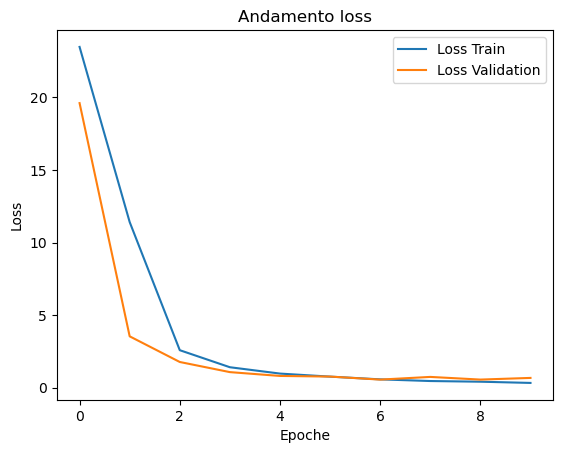

In [14]:
plt.plot(fit_data.history["loss"], label="Loss Train")
plt.plot(fit_data.history["val_loss"], label="Loss Validation")
plt.legend()
plt.title("Andamento loss")
plt.xlabel("Epoche")
plt.ylabel("Loss")

In [15]:
def decodifica_predizione(pred):
    input_len = np.ones(pred.shape[0]) * pred.shape[1]
    # utilizzo la ricerca "greedy" per decodificare la predizione
    results = tf.keras.backend.ctc_decode(pred, input_length=input_len, greedy=True)[0][0][:, :LABEL_LEN]
    # ricostruisco la stringa predetta iterando il risultato
    output_text = []
    for res in results:
        res = tf.strings.reduce_join(num_to_char(res)).numpy().decode("utf-8")
        output_text.append(res)
    return output_text

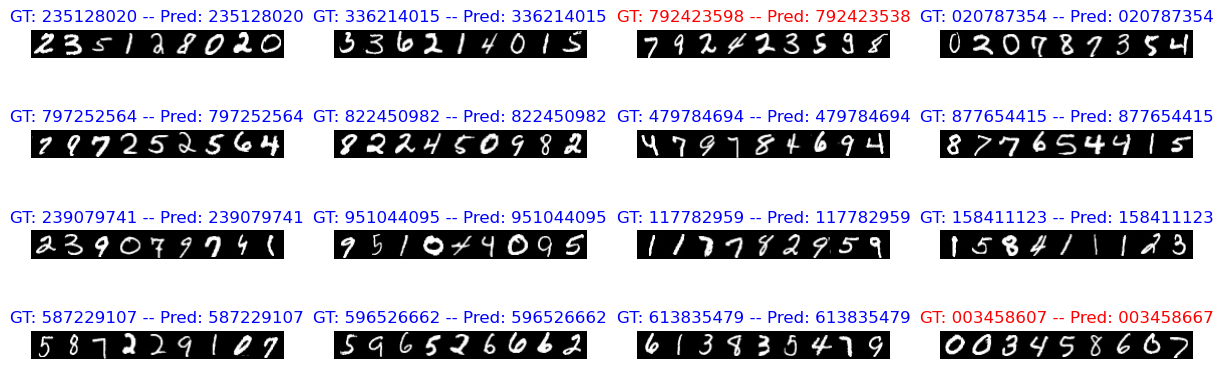

In [16]:
_, axs = plt.subplots(4, 4, figsize=(15, 5))
for i, (imgf, labelstr) in enumerate(zip(test_img, test_lab)):
    sample = prepara_sample(imgf, labelstr)

    pred = pred_model.predict(tf.expand_dims(sample["input_image"], axis=0))
    pred_text = decodifica_predizione(pred)[0]

    axs[i // 4, i % 4].imshow(mpimg.imread(imgf), cmap="gray")
    axs[i // 4, i % 4].title.set_color("red" if labelstr != pred_text else "blue")
    axs[i // 4, i % 4].set_title("GT: %s -- Pred: %s" % (labelstr, pred_text))
    axs[i // 4, i % 4].axis("off")